In [10]:
import os
import sys
import pandas as pd
import numpy as np
PROJECT_ROOT = os.path.abspath(os.path.join(os.path.abspath(''), os.pardir))
sys.path.append(PROJECT_ROOT)
import helpers as db
cursor = db.connect_to_db()
cursor.execute("SELECT table_schema,table_name FROM information_schema.tables ORDER BY table_schema,table_name;")



In [11]:
# getting global temperatures lastdecade from the max date of reporting  (2015-09-01)
def global_temperatures_decade():
    cursor.execute(
    "SELECT *,(date_part('year','2015-12-01'::date)-date_part('year',dt::date)) as lastdecade FROM import.globaltemperatures where (date_part('year','2015-12-01'::date)-date_part('year',dt::date))<=10;"
)
    #return dataframe
    return pd.DataFrame(cursor.fetchall(), columns=[x[0] for x in cursor.description])
  


In [12]:
# Global temperatures in the last century -  (2015-09-01) is the maximum year..

def global_temperatures_last_century():
    cursor.execute(
        "SELECT * FROM import.globaltemperatures where (date_part('year','2015-12-01'::date)-date_part('year',dt::date))<=100;"
    )
    #return dataframe
    return pd.DataFrame(cursor.fetchall(), columns=[x[0] for x in cursor.description])


In [ ]:
# temperatures by the top 5 countries in the last century: Higest pollutors = United States, China, Russia, India, Japan
def temperatures_of_top5():
    cursor.execute(
    "SELECT * FROM import.globaltemperaturesbycountry where (date_part('year','2015-12-01'::date)-date_part('year',dt::date))<=100 and country in ('United States','China','Russia','India','Japan');"
)
    #return dataframe
    return pd.DataFrame(cursor.fetchall(), columns=[x[0] for x in cursor.description])


In [14]:
# add a column for highest pollutors by season.
# usa: winter = 12,1,2, spring = 3,4,5, summer = 6,7,8, fall = 9,10,11
# Russia: winter = 11,12,1,2,3, spring = 4,5 summer = 6,7,8 autumn = 9,10
# china: winter =12,1,2 sprint = 3,4,5 summer = 06,7,8 autum = 9,10,11
# india: winter = 12,1 spring = 2,3 summer = 4,5,6 monsoon 7,8,9(01-15th), autum =9,(15th -) 10,11
# japan: winter = 12,1,2 spring = 3,4,5 summer = 6,7,8 autumn = 9,10,11


def add_season_column():
    cursor.execute(
        "ALTER TABLE import.globaltemperaturesbycountry ADD COLUMN season varchar(10);"
    )
    cursor.execute(
        "UPDATE import.globaltemperaturesbycountry SET season = 'winter' WHERE (date_part('month',dt::date) in (12,1,2) and country = 'United States') or (date_part('month',dt::date) in (11,12,1,2,3) and country = 'Russia') or (date_part('month',dt::date) in (12,1,2) and country = 'China') or (date_part('month',dt::date) in (12,1) and country = 'India') or (date_part('month',dt::date) in (12,1,2) and country = 'Japan');"
    )
    cursor.execute(
        "UPDATE import.globaltemperaturesbycountry SET season = 'spring' WHERE (date_part('month',dt::date) in (3,4,5) and country = 'United States') or (date_part('month',dt::date) in (4,5) and country = 'Russia') or (date_part('month',dt::date) in (3,4,5) and country = 'China') or (date_part('month',dt::date) in (2,3) and country = 'India') or (date_part('month',dt::date) in (3,4,5) and country = 'Japan');"
    )
    cursor.execute(
        "UPDATE import.globaltemperaturesbycountry SET season = 'summer' WHERE (date_part('month',dt::date) in (6,7,8) and country = 'United States') or (date_part('month',dt::date) in (6,7,8) and country = 'Russia') or (date_part('month',dt::date) in (6,7,8) and country = 'China') or (date_part('month',dt::date) in (4,5,6) and country = 'India') or (date_part('month',dt::date) in (6,7,8) and country = 'Japan');"
    )
    cursor.execute(
        "UPDATE import.globaltemperaturesbycountry SET season = 'autumn' WHERE (date_part('month',dt::date) in (9,10) and country = 'Russia') or (date_part('month',dt::date) in (9,10,11) and country = 'China') or (date_part('month',dt::date) in (9,10,11) and country = 'India') or (date_part('month',dt::date) in (9,10,11) and country = 'Japan');"
    )
    cursor.execute(
        "UPDATE import.globaltemperaturesbycountry SET season = 'monsoon' WHERE (date_part('month',dt::date) in (7,8) and country = 'India');"
    )
    cursor.execute(
        "UPDATE import.globaltemperaturesbycountry SET season = 'Fall' where (date_part('month',dt::date) in (9,10,11) and country = 'United States');"
    )
    pass


pass



In [21]:

df = global_temperatures_decade()
# convert landaveragetemperature to float
import altair as alt
df['landaveragetemperature'] = df['landaveragetemperature'].astype(float)
# add a variable for moving average
df['movingaverage'] = df['landaveragetemperature'].rolling(window=5).mean()
df['dt'] = pd.to_datetime(df['dt'])

# create a chart
chart = alt.Chart(df).mark_line().encode(
    x=alt.X('dt', title='Year'),
    y=alt.Y('movingaverage', scale=alt.Scale(zero=False), title='Land Average Temperature (Celsius)'),
).properties(
    width=600,
    height=300
)

chart


/opt/miniconda3/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

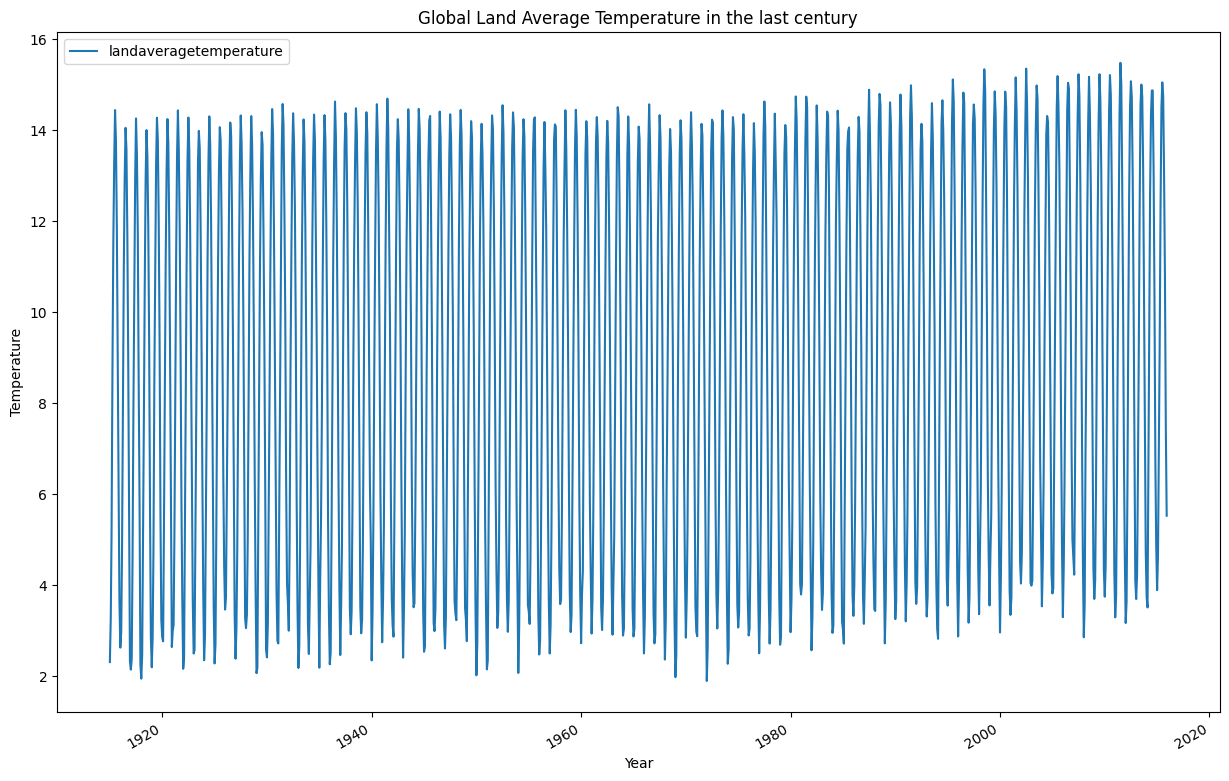

In [ ]:
import matplotlib.pyplot as plt
df = global_temperatures_last_century()
# convert landaveragetemperature to float for easy plotting
df['landaveragetemperature'] = df['landaveragetemperature'].astype(float)
df['dt'] = pd.to_datetime(df['dt'])

# group by year and take the mean
df.plot(x='dt', y='landaveragetemperature', kind='line', figsize=(15, 10), title='Global Land Average Temperature in the last century')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.show()




In [ ]:

add_season_column()
df = temperatures_of_top5().copy()
df['dt'] = pd.to_datetime(df['dt'])
df['averagetemperature'] = df['averagetemperature'].replace('', np.nan)
df['averagetemperature'] = df['averagetemperature'].astype(float)

In [ ]:
# create 5 dataframes for each country
usa = df[df['country'] == 'United States'].copy()
china = df[df['country'] == 'China'].copy()
russia = df[df['country'] == 'Russia'].copy()
india = df[df['country'] == 'India'].copy()
japan = df[df['country'] == 'Japan'].copy()
usa.head(5).sort_index()

,dt,averagetemperature,averagetemperatureuncertainty,country,season
1242,1922-02-01,-2.384,0.209,United States,winter
1243,1922-12-01,-1.680,0.14,United States,winter
1244,1923-01-01,-1.925,0.268,United States,winter
1245,1923-02-01,-3.042,0.271,United States,winter
1246,1923-12-01,-1.377,0.378,United States,winter


In [ ]:
import altair as alt
alt.Chart(usa).mark_line().encode( 
    x='dt',
    y='averagetemperature',
    color='season',
    strokeDash='season',
)

/opt/miniconda3/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [ ]:
import altair as alt

alt.Chart(china).mark_line().encode(
    x='dt',
    y='averagetemperature',
    color='season',
    strokeDash='season',
)

alt.Chart(...)

In [ ]:
import altair as alt

alt.Chart(india).mark_line().encode(
    x='dt',
    y='averagetemperature',
    color='season',
    strokeDash='season',
)

alt.Chart(...)

In [ ]:
import altair as alt

alt.Chart(japan).mark_line().encode(
    x='dt',
    y='averagetemperature',
    color='season',
    strokeDash='season',
)

alt.Chart(...)